In [ ]:
#|default_exp data.preparation

# Data preparation

>Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#|export
from __future__ import annotations
from tsai.imports import *
from tsai.utils import *
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/devengqc/mambaforge/envs/tsai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#|export
def prepare_idxs(o, shape=None):
    if o is None:
        return slice(None)
    elif is_slice(o) or isinstance(o, Integral):
        return o
    else:
        if shape is not None:
            return np.array(o).reshape(shape)
        else:
            return np.array(o)
        
def prepare_sel_vars_and_steps(sel_vars=None, sel_steps=None, idxs=False):
    sel_vars = prepare_idxs(sel_vars)
    sel_steps = prepare_idxs(sel_steps)
    if not is_slice(sel_vars) and not isinstance(sel_vars, Integral):
        if is_slice(sel_steps) or isinstance(sel_steps, Integral):
            _sel_vars = [sel_vars, sel_vars.reshape(1, -1)]
        else:
            _sel_vars = [sel_vars.reshape(-1, 1), sel_vars.reshape(1, -1, 1)]
    else:
        _sel_vars = [sel_vars] * 2
    if not is_slice(sel_steps) and not isinstance(sel_steps, Integral):
        if is_slice(sel_vars) or isinstance(sel_vars, Integral):
            _sel_steps = [sel_steps, sel_steps.reshape(1, -1)]
        else:
            _sel_steps = [sel_steps.reshape(1, -1), sel_steps.reshape(1, 1, -1)]
    else:
        _sel_steps = [sel_steps] * 2
    if idxs:
        n_dim = np.sum([isinstance(o, np.ndarray) for o in [sel_vars, sel_steps]])
        idx_shape = (-1,) + (1,) * n_dim
        return _sel_vars, _sel_steps, idx_shape
    else:
        return _sel_vars[0], _sel_steps[0]
    
def apply_sliding_window(
    data, # and array-like object with the input data 
    window_len:int|list, # sliding window length. When using a list, use negative numbers and 0.
    horizon:int|list=0, # horizon
    x_vars:int|list|None=None, # indices of the independent variables
    y_vars:int|list|None=None, # indices of the dependent variables (target). [] means no y will be created. None means all variables.
    ):
    "Applies a sliding window on an array-like input to generate a 3d X (and optionally y)"
  
    if isinstance(data, pd.DataFrame): data = data.to_numpy()
    if isinstance(window_len, list):
        assert np.max(window_len) == 0
        x_steps = abs(np.min(window_len)) + np.array(window_len)
        window_len = abs(np.min(window_len)) + 1
    else:
        x_steps = None
        
    X_data_windowed = np.lib.stride_tricks.sliding_window_view(data, window_len, axis=0)

    # X
    sel_x_vars, sel_x_steps = prepare_sel_vars_and_steps(x_vars, x_steps)
    if horizon == 0:
        X = X_data_windowed[:, sel_x_vars, sel_x_steps]
    else:
        X = X_data_windowed[:-np.max(horizon):, sel_x_vars, sel_x_steps]
    if x_vars is not None and isinstance(x_vars, Integral):
        X = X[:, None] # keep 3 dim

    # y
    if y_vars == []:
        y = None
    else:
        if isinstance(horizon, Integral) and horizon == 0:
            y = data[-len(X):, y_vars]
        else:
            y_data_windowed = np.lib.stride_tricks.sliding_window_view(data, np.max(horizon) + 1, axis=0)[-len(X):]
            y_vars, y_steps = prepare_sel_vars_and_steps(y_vars, horizon)
            y = np.squeeze(y_data_windowed[:, y_vars, y_steps])
    return X, y

In [ ]:
data = np.arange(20).reshape(-1,1).repeat(3, 1) * np.array([1, 10, 100])
df = pd.DataFrame(data, columns=['feat_1', 'feat_2', 'feat_3'])
df.head()

,feat_1,feat_2,feat_3
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400


In [ ]:
window_len = 8
horizon = 1
x_vars = None
y_vars = None
X, y = apply_sliding_window(data, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, data))
print(np.shares_memory(y, data))
print(X.shape, y.shape)
test_eq(X.shape, (len(df) - (window_len - 1 + horizon), df.shape[1], window_len))
test_eq(y.shape, (len(df) - (window_len - 1 + horizon), df.shape[1]))
X[0], y[0]

True
True
(12, 3, 8) (12, 3)


(array([[  0,   1,   2,   3,   4,   5,   6,   7],
        [  0,  10,  20,  30,  40,  50,  60,  70],
        [  0, 100, 200, 300, 400, 500, 600, 700]]),
 array([  8,  80, 800]))

In [ ]:
window_len = 8
horizon = 1
x_vars = None
y_vars = 0
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)
test_eq(X.shape, (len(df) - (window_len - 1 + horizon), df.shape[1], window_len))
test_eq(y.shape, (len(df) - (window_len - 1 + horizon),))
X[0], y[0]

True
True
(12, 3, 8) (12,)


(array([[  0,   1,   2,   3,   4,   5,   6,   7],
        [  0,  10,  20,  30,  40,  50,  60,  70],
        [  0, 100, 200, 300, 400, 500, 600, 700]]),
 8)

In [ ]:
window_len = 8
horizon = [1, 2]
x_vars = 0
y_vars = [1, 2]
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)
test_eq(X.shape, (len(df) - (window_len - 1 + max(horizon)), 1, window_len))
test_eq(y.shape, (len(df) - (window_len - 1 + max(horizon)), len(y_vars), len(horizon)))
X[0], y[0]

True
False
(11, 1, 8) (11, 2, 2)


(array([[0, 1, 2, 3, 4, 5, 6, 7]]),
 array([[ 80,  90],
        [800, 900]]))

In [ ]:
window_len = [-4, -2, -1, 0]
horizon = [1, 2, 4]
x_vars = 0
y_vars = [1, 2]
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)
test_eq(X.shape, (12, 1, 4))
test_eq(y.shape, (12, 2, 3))
X[0], y[0]

False
False
(12, 1, 4) (12, 2, 3)


(array([[0, 2, 3, 4]]),
 array([[ 50,  60,  80],
        [500, 600, 800]]))

In [ ]:
#|export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, steps_in_rows=False, to3d=True, splits=None,
          sort_by=None, ascending=True, y_func=None, return_names=False):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to create a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    steps_in_rows: flag to indicate if each step is in a different row or in a different column (default).
    to3d: turns X to 3d (including univariate time series)
    sort_by: this is used to pass any colum/s that are needed to sort the steps in the sequence. 
             If you pass a sample_col and/ or feat_col these will be automatically used before the sort_by column/s, and 
             you don't need to add them to the sort_by column/s list. 
    y_func: function used to calculate y for each sample (and target_col)
    return_names: flag to return the names of the columns from where X was generated
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        if sample_col[0] not in sort_cols: sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        if feat_col[0] not in sort_cols: sort_cols += listify(feat_col)
        passed_cols += feat_col
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col
    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if target_col is not None: 
        if any([t for t in target_col if t in data_cols]): print(f"Are you sure you want to include {target_col} in X?")
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if to3d:
        if feat_col is not None:
            n_feats = df[feat_col[0]].nunique()
            X = X.reshape(n_samples, n_feats, -1)
        elif steps_in_rows:
            X = X.reshape(n_samples, -1, len(data_cols)).swapaxes(1,2)
        else:
            X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None:
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else:
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: 
        if return_names: return X, y, data_cols
        else: return X, y
    else: 
        if return_names: return split_xy(X, y, splits), data_cols
        return split_xy(X, y, splits)

In [ ]:
#|export  
def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
df = pd.DataFrame()
df['sample_id'] = np.array([1,1,1,2,2,2,3,3,3])
df['var1'] = df['sample_id'] * 10 + df.index.values
df['var2'] = df['sample_id'] * 100 + df.index.values
df

,sample_id,var1,var2
0,1,10,100
1,1,11,101
2,1,12,102
3,2,23,203
4,2,24,204
5,2,25,205
6,3,36,306
7,3,37,307
8,3,38,308


In [ ]:
X_df, y_df = df2Xy(df, sample_col='sample_id', steps_in_rows=True)
test_eq(X_df[0], np.array([[10, 11, 12], [100, 101, 102]]))

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array([0,1,2])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array([100,200,300])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,520,5,0.459764,-0.627694,1.925696,-0.605618,-0.145010,1.938224,2.0,2.0
1,166,4,0.652253,0.780789,3.093799,0.694445,-1.425392,-0.014826,1.0,1.0
2,526,6,-0.569884,-0.831256,0.234741,-0.687848,-0.138140,-0.734357,1.0,1.0
3,612,3,-0.537606,0.717642,-1.024045,0.079935,0.086735,0.224942,2.0,2.0
4,826,2,1.230088,0.780170,0.601925,-0.919732,-0.915087,-0.764003,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,954,9,-0.959098,-0.577773,-0.427721,0.084002,1.245782,0.274125,1.0,1.0
9996,224,1,0.723100,0.738433,-0.891629,0.355998,-0.081499,1.297328,1.0,1.0
9997,679,7,-1.101856,-0.261253,1.498759,1.439577,-0.152510,-0.178197,1.0,1.0
9998,471,9,-0.123062,-0.021511,-0.756558,-0.950359,0.738793,0.980541,2.0,2.0


In [ ]:
from scipy.stats import mode

In [ ]:
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], sort_by=['sample_id', 'feat_id'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO

In [ ]:
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;0
    alice;6;7;1
    eve;11;12;2
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,0
1,alice,6,7,1
2,eve,11,12,2


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array([1, 2, 0]))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;0
    alice;1;6;1
    eve;1;11;2
    
    rob;2;3;0
    alice;2;7;1
    eve;2;12;2
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,0
1,alice,1,6,1
2,eve,1,11,2
3,rob,2,3,0
4,alice,2,7,1
5,eve,2,12,2


[[[ 6  7]]

 [[11 12]]

 [[ 2  3]]] [1 2 0]


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;0
    rob;yellow;3;4;0
    rob;blue;4;5;0
    rob;red;5;6;0
    alice;green;6;7;1
    alice;yellow;7;8;1
    alice;blue;8;9;1
    alice;red;9;10;1
    eve;yellow;11;12;2
    eve;green;10;11;2
    eve;blue;12;12;2
    eve;red;13;14;2
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
3,rob,red,5,6,0
9,eve,green,10,11,2
1,rob,yellow,3,4,0
0,rob,green,2,3,0
2,rob,blue,4,5,0
11,eve,red,13,14,2
5,alice,yellow,7,8,1
10,eve,blue,12,12,2
7,alice,red,9,10,1
8,eve,yellow,11,12,2


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [1 2 0]


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;0;0
    rob;yellow;3;4;0;0
    rob;blue;4;5;0;0
    rob;red;5;6;0;0
    alice;green;6;7;1;0
    alice;yellow;7;8;1;0
    alice;blue;8;9;1;0
    alice;red;9;10;1;0
    eve;yellow;11;12;2;1
    eve;green;10;11;2;1
    eve;blue;12;12;2;1
    eve;red;13;14;2;1
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,0,0
1,rob,yellow,3,4,0,0
2,rob,blue,4,5,0,0
3,rob,red,5,6,0,0
4,alice,green,6,7,1,0
5,alice,yellow,7,8,1,0
6,alice,blue,8,9,1,0
7,alice,red,9,10,1,0
8,eve,yellow,11,12,2,1
9,eve,green,10,11,2,1


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [[1 0]
 [2 1]
 [0 0]]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;0
    rob;yellow;3;4;0
    rob;blue;4;5;0
    rob;red;5;6;0
    alice;green;6;7;1
    alice;yellow;7;8;1
    alice;blue;8;9;1
    alice;red;9;10;1
    eve;yellow;11;12;2
    eve;green;10;11;2
    eve;blue;12;12;2
    eve;red;13;14;2
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
11,eve,red,13,14,2
6,alice,blue,8,9,1
7,alice,red,9,10,1
3,rob,red,5,6,0
8,eve,yellow,11,12,2
9,eve,green,10,11,2
1,rob,yellow,3,4,0
4,alice,green,6,7,1
5,alice,yellow,7,8,1
0,rob,green,2,3,0


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;0
    rob;yellow;1;3;0
    rob;blue;1;4;0
    rob;red;1;5;0
    alice;green;1;6;1
    alice;yellow;1;7;1
    alice;blue;1;8;1
    alice;red;1;9;1
    eve;yellow;1;11;2
    eve;green;1;10;2
    eve;blue;1;12;2
    eve;red;1;13;2
    
    rob;green;2;3;0
    rob;yellow;2;4;0
    rob;blue;2;5;0
    rob;red;2;6;0
    alice;green;2;7;1
    alice;yellow;2;8;1
    alice;blue;2;9;1
    alice;red;2;10;1
    eve;yellow;2;12;2
    eve;green;2;11;2
    eve;blue;2;13;2
    eve;red;2;14;2
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,0
1,rob,yellow,1,3,0
2,rob,blue,1,4,0
3,rob,red,1,5,0
4,alice,green,1,6,1
5,alice,yellow,1,7,1
6,alice,blue,1,8,1
7,alice,red,1,9,1
8,eve,yellow,1,11,2
9,eve,green,1,10,2


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 13]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [1 2 0]


In [ ]:
#|export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
#|export
def add_missing_value_cols(df, cols=None, dtype=float, fill_value=None):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
        if fill_value is not None:
            df[col].fillna(fill_value)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

,A,B,missing_A,missing_B
0,0.592329,-0.468067,0.0,0.0
1,NaN,-0.947533,1.0,0.0
2,-0.373838,-1.225096,0.0,0.0
3,NaN,0.265217,1.0,0.0
4,-0.325841,-1.910127,0.0,0.0
5,0.152924,0.516176,0.0,0.0
6,-0.189297,-0.367993,0.0,0.0
7,-0.218595,-0.513171,0.0,0.0
8,-1.945714,-0.081274,0.0,0.0
9,-0.007987,-0.208418,0.0,0.0


In [ ]:
#|export
def add_missing_timestamps(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing timestamps in a dataframe to a desired frequency
    Args:
        df:                      pandas DataFrame
        datetime_col:            column that contains the datetime data (without duplicates within groups)
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date, freq=freq)] for min_date, max_date, key in \
                                       zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(dates, name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    return df

In [ ]:
# Filling dates between min and max dates
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

,date,feature1,feature2
0,2021-05-01,0.823040,0.938756
1,2021-05-03,0.929857,0.306231
2,2021-05-05,0.624034,0.036997
3,2021-05-06,0.781609,0.705914
4,2021-05-07,0.782805,0.819079


In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby=None, 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(output_df, expected_output_df)

,date,feature1,feature2
0,2021-05-01,0.823040,0.938756
1,2021-05-02,NaN,NaN
2,2021-05-03,0.929857,0.306231
3,2021-05-04,NaN,NaN
4,2021-05-05,0.624034,0.036997
5,2021-05-06,0.781609,0.705914
6,2021-05-07,0.782805,0.819079


In [ ]:
# Filling dates between min and max dates for each value in groupby column
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,11,13]).reset_index(drop=True)

date_df_with_missing_dates

,date,id,feature1,feature2
0,2021-05-03,0,0.800400,0.535214
1,2021-05-05,0,0.652190,0.757534
2,2021-05-06,0,0.219929,0.118050
3,2021-05-07,0,0.699135,0.787578
4,2021-05-01,1,0.270739,0.910241
5,2021-05-03,1,0.321630,0.042185
6,2021-05-04,1,0.768111,0.614382
7,2021-05-06,1,0.471109,0.962955


In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,13]).reset_index(drop=True)  
expected_output_df.loc[[1,6,9], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True)
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-03,0,0.800400,0.535214
1,2021-05-04,0,NaN,NaN
2,2021-05-05,0,0.652190,0.757534
3,2021-05-06,0,0.219929,0.118050
4,2021-05-07,0,0.699135,0.787578
5,2021-05-01,1,0.270739,0.910241
6,2021-05-02,1,NaN,NaN
7,2021-05-03,1,0.321630,0.042185
8,2021-05-04,1,0.768111,0.614382
9,2021-05-05,1,NaN,NaN


In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,11,13], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False)
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01,0,NaN,NaN
1,2021-05-02,0,NaN,NaN
2,2021-05-03,0,0.800400,0.535214
3,2021-05-04,0,NaN,NaN
4,2021-05-05,0,0.652190,0.757534
5,2021-05-06,0,0.219929,0.118050
6,2021-05-07,0,0.699135,0.787578
7,2021-05-01,1,0.270739,0.910241
8,2021-05-02,1,NaN,NaN
9,2021-05-03,1,0.321630,0.042185


In [ ]:
# Filling dates between min and max timestamps
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates

,date,feature1,feature2
0,2021-05-01 00:00:00,0.607245,0.187488
1,2021-05-01 08:00:00,0.132170,0.190835
2,2021-05-01 16:00:00,0.403469,0.503333
3,2021-05-01 20:00:00,0.280599,0.434733


In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df.loc[[1,3], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 'date', groupby=None, fill_value=np.nan, range_by_group=False, freq='4H')
test_eq(output_df, expected_output_df)

,date,feature1,feature2
0,2021-05-01 00:00:00,0.607245,0.187488
1,2021-05-01 04:00:00,NaN,NaN
2,2021-05-01 08:00:00,0.132170,0.190835
3,2021-05-01 12:00:00,NaN,NaN
4,2021-05-01 16:00:00,0.403469,0.503333
5,2021-05-01 20:00:00,0.280599,0.434733


In [ ]:
# Filling missing values between min and max timestamps for each value in groupby column

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,3,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.060752,0.435344
1,2021-05-01 16:00:00,0,0.107559,0.418523
2,2021-05-01 20:00:00,0,0.554472,0.847948
3,2021-05-01 00:00:00,1,0.641016,0.221956
4,2021-05-01 04:00:00,1,0.369471,0.811161
5,2021-05-01 16:00:00,1,0.651488,0.640005


In [ ]:
# groupby='id', range_by_group=True
expected_output_df = date_df.drop([0,1,11]).reset_index(drop=True)  
expected_output_df.loc[[1,6,7], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=True, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.060752,0.435344
1,2021-05-01 12:00:00,0,NaN,NaN
2,2021-05-01 16:00:00,0,0.107559,0.418523
3,2021-05-01 20:00:00,0,0.554472,0.847948
4,2021-05-01 00:00:00,1,0.641016,0.221956
5,2021-05-01 04:00:00,1,0.369471,0.811161
6,2021-05-01 08:00:00,1,NaN,NaN
7,2021-05-01 12:00:00,1,NaN,NaN
8,2021-05-01 16:00:00,1,0.651488,0.640005


In [ ]:
# groupby='id', range_by_group=False
expected_output_df = date_df.copy() 
expected_output_df.loc[[0,1,3,8,9,11], ['feature1', 'feature2']] = np.nan
display(expected_output_df)
output_df = add_missing_timestamps(date_df_with_missing_dates, 
                                   'date', 
                                   groupby='id', 
                                   fill_value=np.nan, 
                                   range_by_group=False, 
                                   freq='4H')
test_eq(expected_output_df, output_df)

,date,id,feature1,feature2
0,2021-05-01 00:00:00,0,NaN,NaN
1,2021-05-01 04:00:00,0,NaN,NaN
2,2021-05-01 08:00:00,0,0.060752,0.435344
3,2021-05-01 12:00:00,0,NaN,NaN
4,2021-05-01 16:00:00,0,0.107559,0.418523
5,2021-05-01 20:00:00,0,0.554472,0.847948
6,2021-05-01 00:00:00,1,0.641016,0.221956
7,2021-05-01 04:00:00,1,0.369471,0.811161
8,2021-05-01 08:00:00,1,NaN,NaN
9,2021-05-01 12:00:00,1,NaN,NaN


In [ ]:
# No groups, with duplicate dates ==> FAILS
dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))
data[:, 2] = np.random.rand(len(dates))
cols = ['date', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([1,3]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby=None, fill_value=np.nan, range_by_group=False, freq='4H'), )

,date,feature1,feature2
0,2021-05-01 00:00:00,0.963446,0.058628
1,2021-05-01 08:00:00,0.540332,0.623463
2,2021-05-01 16:00:00,0.782975,0.014224
3,2021-05-01 16:00:00,0.492976,0.568369


In [ ]:
# groupby='id', range_by_group=True, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=True, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.421303,0.167113
1,2021-05-01 12:00:00,0,0.029462,0.762620
2,2021-05-01 16:00:00,0,0.339028,0.123963
3,2021-05-01 16:00:00,0,0.672523,0.984310
4,2021-05-01 00:00:00,1,0.956095,0.277770
5,2021-05-01 04:00:00,1,0.256796,0.013002
6,2021-05-01 16:00:00,1,0.568570,0.067022


In [ ]:
# groupby='id', range_by_group=FALSE, with duplicate dates ==> FAILS

dates = pd.date_range('2021-05-01 000:00', '2021-05-01 20:00', freq='4H').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 4))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))
data[:, 3] = np.random.rand(len(dates))
cols = ['date', 'id', 'feature1', 'feature2']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float, 'feature2': float})
date_df_with_missing_dates = date_df.drop([0,1,8,9,11]).reset_index(drop=True)
date_df_with_missing_dates.loc[3, 'date'] = date_df_with_missing_dates.loc[2, 'date']
display(date_df_with_missing_dates)
test_fail(add_missing_timestamps, args=[date_df_with_missing_dates, 'date'], kwargs=dict(groupby='id', fill_value=np.nan, range_by_group=False, freq='4H'), 
          contains='cannot handle a non-unique multi-index!')

,date,id,feature1,feature2
0,2021-05-01 08:00:00,0,0.078290,0.906822
1,2021-05-01 12:00:00,0,0.452660,0.031468
2,2021-05-01 16:00:00,0,0.926381,0.579323
3,2021-05-01 16:00:00,0,0.897053,0.779685
4,2021-05-01 00:00:00,1,0.549585,0.611056
5,2021-05-01 04:00:00,1,0.742452,0.962581
6,2021-05-01 16:00:00,1,0.194525,0.289729


In [ ]:
#|export
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    
    Available options: microsecond, millisecond, second, minute, hour, day = day_of_month = dayofmonth, 
    day_of_week = weekday = dayofweek, day_of_year = dayofyear, week = week_of_year = weekofyear, month and year
    """

    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

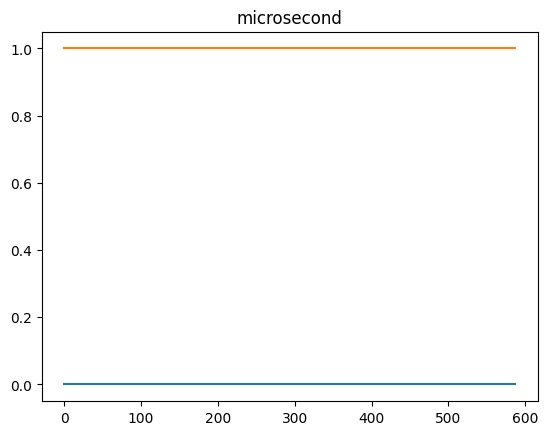

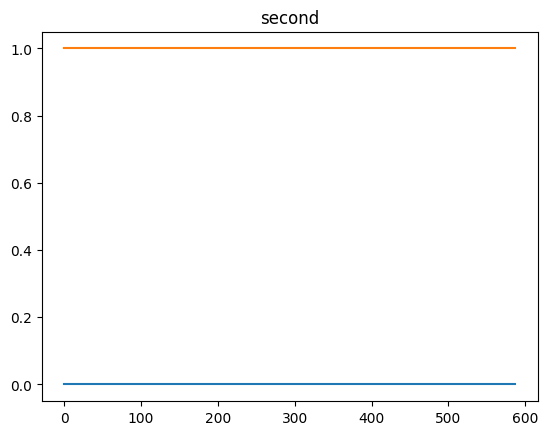

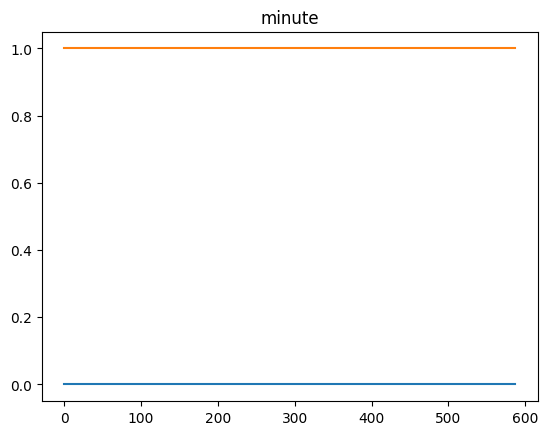

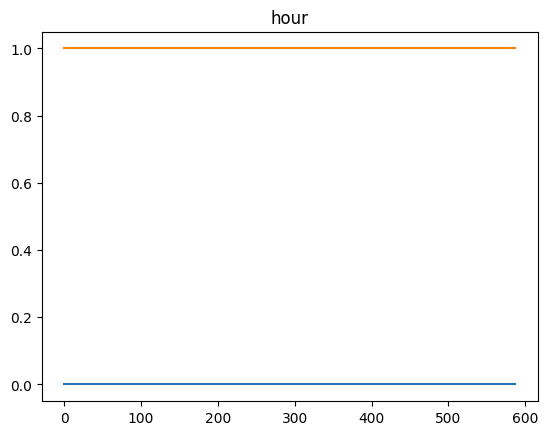

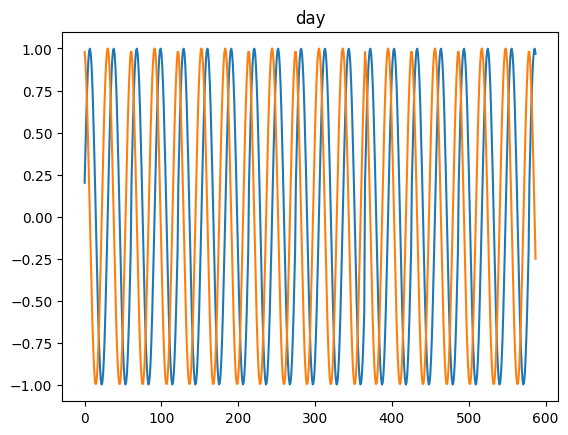

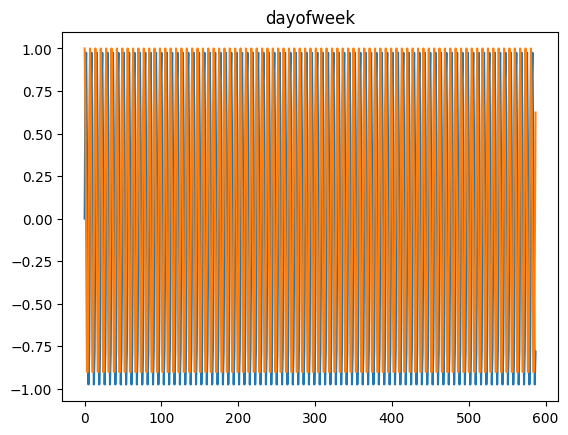

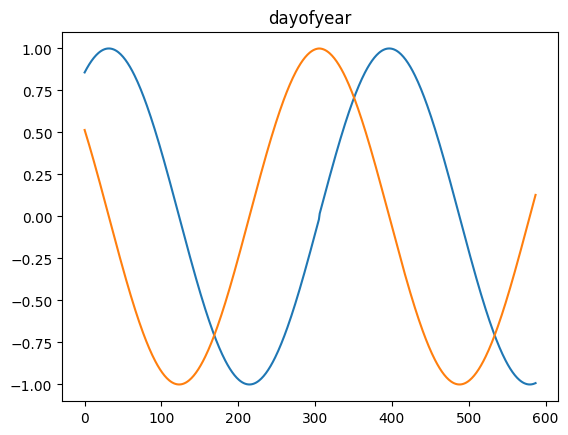

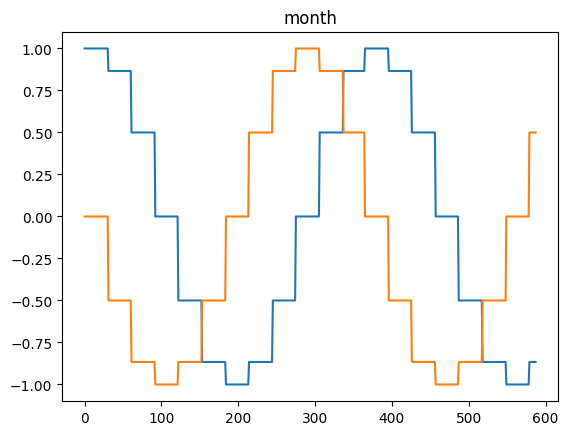

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    tdf = pd.DataFrame(pd.date_range('2021-03-01', datetime.datetime.today()), columns=['date'])
    a,b = time_encoding(tdf.date, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

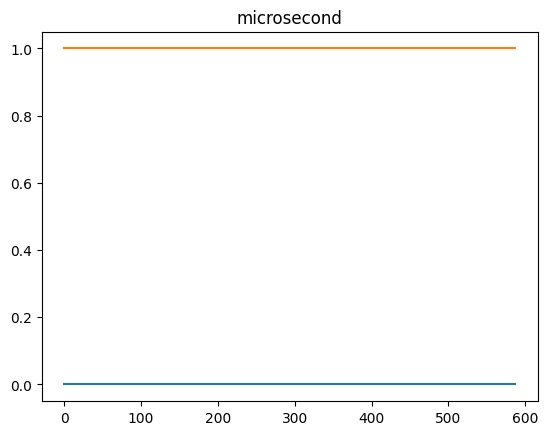

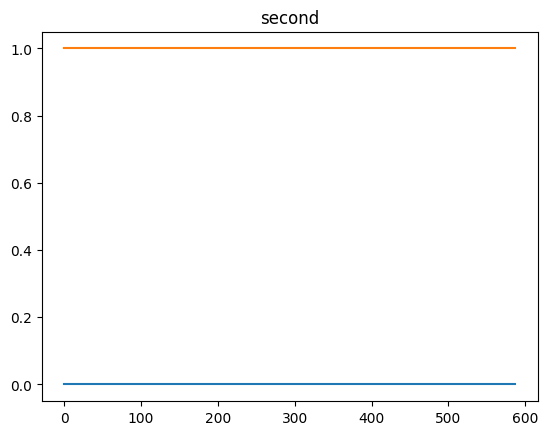

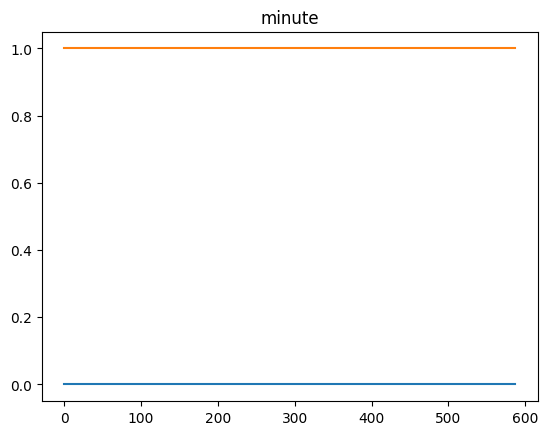

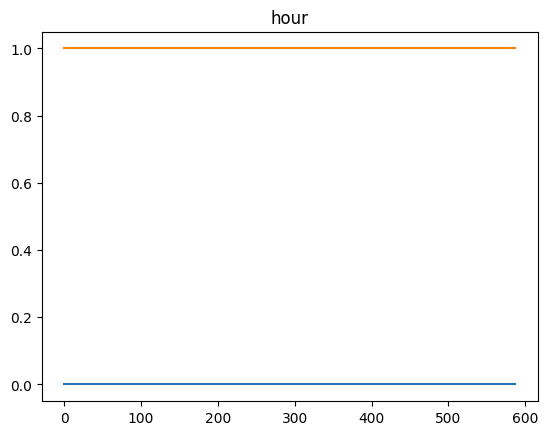

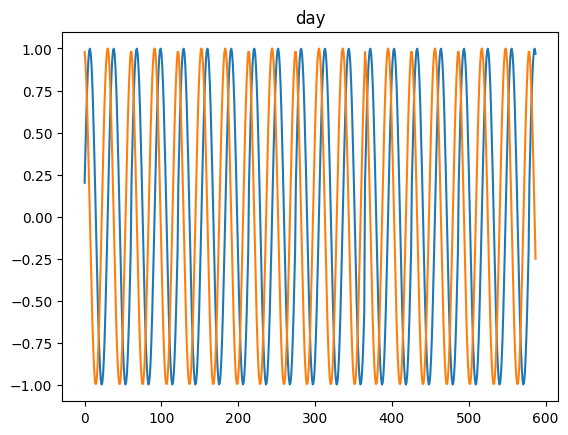

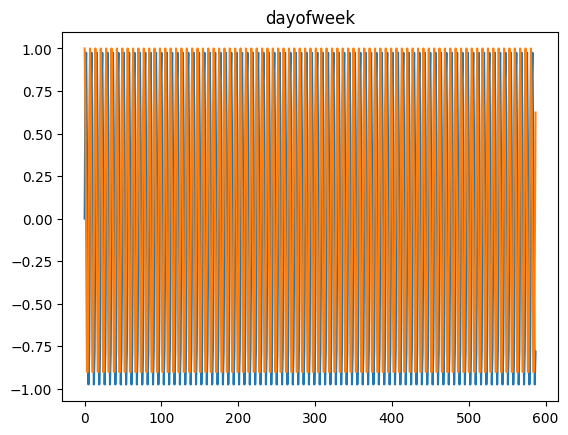

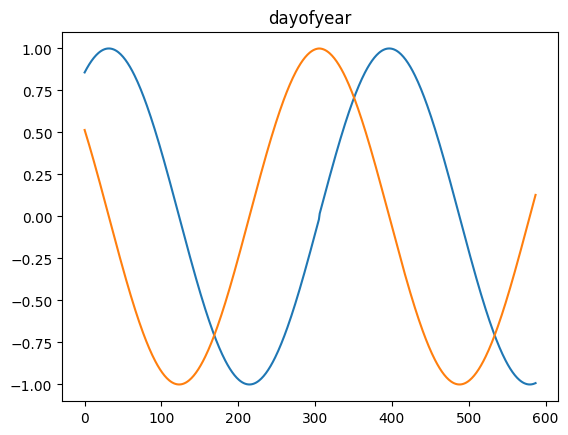

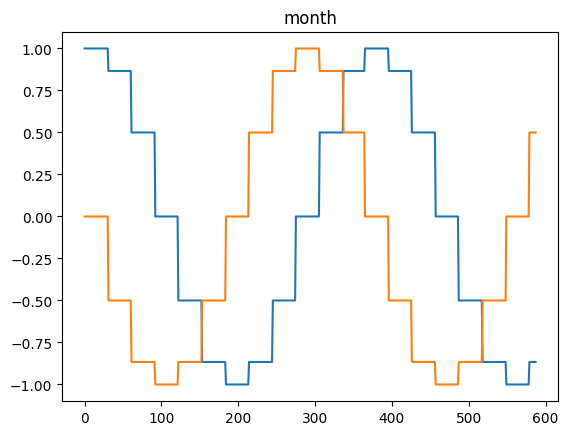

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    dateindex = pd.date_range('2021-03-01', datetime.datetime.today())
    a,b = time_encoding(dateindex, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

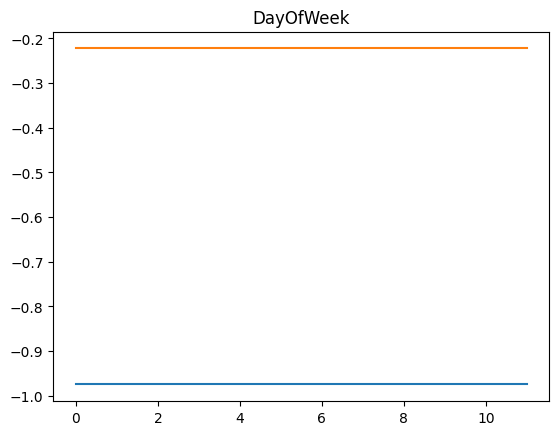

,date,id,feature1,feature2,dow_sin,dow_cos
0,2021-05-01 00:00:00,0,0.643714,0.739240,-0.974928,-0.222521
1,2021-05-01 04:00:00,0,0.056759,0.850406,-0.974928,-0.222521
2,2021-05-01 08:00:00,0,0.078290,0.906822,-0.974928,-0.222521
3,2021-05-01 12:00:00,0,0.452660,0.031468,-0.974928,-0.222521
4,2021-05-01 16:00:00,0,0.926381,0.579323,-0.974928,-0.222521
5,2021-05-01 20:00:00,0,0.897053,0.779685,-0.974928,-0.222521
6,2021-05-01 00:00:00,1,0.549585,0.611056,-0.974928,-0.222521
7,2021-05-01 04:00:00,1,0.742452,0.962581,-0.974928,-0.222521
8,2021-05-01 08:00:00,1,0.243666,0.189091,-0.974928,-0.222521
9,2021-05-01 12:00:00,1,0.021391,0.683905,-0.974928,-0.222521


In [ ]:
dow_sin, dow_cos = time_encoding(date_df['date'], 'dayofweek')
plt.plot(dow_sin)
plt.plot(dow_cos)
plt.title('DayOfWeek')
plt.show()
date_df['dow_sin'] = dow_sin
date_df['dow_cos'] = dow_cos
date_df

In [ ]:
#|export
def forward_gaps(o, normalize=True):
    """Number of sequence steps since previous real value along the last dimension of 3D arrays or tensors"""

    b,c,s=o.shape
    if isinstance(o, torch.Tensor):
        o = torch.cat([torch.zeros(*o.shape[:2], 1, device=o.device), o], -1)
        idx = torch.where(o==o, torch.arange(s + 1, device=o.device), 0)
        idx = torch.cummax(idx, axis=-1).values
        gaps = (torch.arange(1, s + 2, device=o.device) - idx)[..., :-1]
    elif isinstance(o, np.ndarray):
        o = np.concatenate([np.zeros((*o.shape[:2], 1)), o], -1)
        idx = np.where(o==o, np.arange(s + 1), 0)
        idx = np.maximum.accumulate(idx, axis=-1)
        gaps = (np.arange(1, s + 2) - idx)[..., :-1]
    if normalize:
        gaps = gaps / s
    return gaps


def backward_gaps(o, normalize=True):
    """Number of sequence steps to next real value along the last dimension of 3D arrays or tensors"""

    if isinstance(o, torch.Tensor): o = torch_flip(o, -1)
    elif isinstance(o, np.ndarray): o = o[..., ::-1]
    gaps = forward_gaps(o, normalize=normalize)
    if isinstance(o, torch.Tensor): gaps = torch_flip(gaps, -1)
    elif isinstance(o, np.ndarray): gaps = gaps[..., ::-1]
    return gaps


def nearest_gaps(o, normalize=True):
    """Number of sequence steps to nearest real value along the last dimension of 3D arrays or tensors"""

    forward = forward_gaps(o, normalize=normalize)
    backward = backward_gaps(o, normalize=normalize)
    if isinstance(o, torch.Tensor):
        return torch.fmin(forward, backward)
    elif isinstance(o, np.ndarray):
        return np.fmin(forward, backward)


def get_gaps(o : torch.Tensor, forward : bool = True, backward : bool = True, 
             nearest : bool = True, normalize : bool = True):
    """Number of sequence steps from previous, to next and/or to nearest real value along the 
    last dimension of 3D arrays or tensors"""
    
    _gaps = []
    if forward or nearest:  
        fwd = forward_gaps(o, normalize=normalize)
        if forward: 
            _gaps.append(fwd)
    if backward or nearest: 
        bwd = backward_gaps(o, normalize=normalize)
        if backward: 
            _gaps.append(bwd)
    if nearest:
        if isinstance(o, torch.Tensor): 
            nst = torch.fmin(fwd, bwd)
        elif isinstance(o, np.ndarray): 
            nst = np.fmin(fwd, bwd)
        _gaps.append(nst)
    if isinstance(o, torch.Tensor): 
        gaps = torch.cat(_gaps, 1)
    elif isinstance(o, np.ndarray):
        gaps = np.concatenate(_gaps, 1)
    return gaps

In [ ]:
t = torch.rand(1, 2, 8)
arr = t.numpy()
t[t <.6] = np.nan
test_ge(nearest_gaps(t).min().item(), 0)
test_ge(nearest_gaps(arr).min(), 0)
test_le(nearest_gaps(t).min().item(), 1)
test_le(nearest_gaps(arr).min(), 1)
test_eq(torch.isnan(forward_gaps(t)).sum(), 0)
test_eq(np.isnan(forward_gaps(arr)).sum(), 0)
ag = get_gaps(t)
test_eq(ag.shape, (1,6,8))
test_eq(torch.isnan(ag).sum(), 0)

In [ ]:
#|export
def add_delta_timestamp_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True, normalize=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest:
        if groupby:
            forward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: forward_gaps(x.values.transpose(1,0)[None], normalize=normalize))
            forward_time_gaps = np.concatenate(forward_time_gaps, -1)[0].transpose(1,0)
        else:
            forward_time_gaps = forward_gaps(df[cols].values.transpose(1,0)[None], normalize=normalize)[0].transpose(1,0)
        if forward : 
            df[[f'{col}_dt_fwd' for col in cols]] = forward_time_gaps
            df[[f'{col}_dt_fwd' for col in cols]] = df[[f'{col}_dt_fwd' for col in cols]]
    if backward or nearest:
        if groupby:
            backward_time_gaps = df[cols].groupby(df[groupby]).apply(lambda x: backward_gaps(x.values.transpose(1,0)[None], normalize=normalize))
            backward_time_gaps = np.concatenate(backward_time_gaps, -1)[0].transpose(1,0)
        else:
            backward_time_gaps = backward_gaps(df[cols].values.transpose(1,0)[None], normalize=normalize)[0].transpose(1,0)
        if backward: 
            df[[f'{col}_dt_bwd' for col in cols]] = backward_time_gaps
            df[[f'{col}_dt_bwd' for col in cols]] = df[[f'{col}_dt_bwd' for col in cols]]
    if nearest:
        df[[f'{col}_dt_nearest' for col in cols]] = np.fmin(forward_time_gaps, backward_time_gaps)
        df[[f'{col}_dt_nearest' for col in cols]] = df[[f'{col}_dt_nearest' for col in cols]]
    return df

In [ ]:
# Add delta timestamp features for the no groups setting
dates = pd.date_range('2021-05-01', '2021-05-07').values
data = np.zeros((len(dates), 2))
data[:, 0] = dates
data[:, 1] = np.random.rand(len(dates))

cols = ['date', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'feature1': float})
date_df.loc[[1,3,4],'feature1'] = np.nan
date_df

,date,feature1
0,2021-05-01,0.412257
1,2021-05-02,NaN
2,2021-05-03,0.265643
3,2021-05-04,NaN
4,2021-05-05,NaN
5,2021-05-06,0.144675
6,2021-05-07,0.110498


In [ ]:
# No groups
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = np.array([1,1,2,1,2,3,1])
expected_output_df['feature1_dt_bwd'] = np.array([2,1,3,2,1,1,1])
expected_output_df['feature1_dt_nearest'] = np.array([1,1,2,1,1,1,1])

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1', normalize=False)
test_eq(expected_output_df, output_df)

,date,feature1,feature1_dt_fwd,feature1_dt_bwd,feature1_dt_nearest
0,2021-05-01,0.412257,1,2,1
1,2021-05-02,NaN,1,1,1
2,2021-05-03,0.265643,2,3,2
3,2021-05-04,NaN,1,2,1
4,2021-05-05,NaN,2,1,1
5,2021-05-06,0.144675,3,1,1
6,2021-05-07,0.110498,1,1,1


In [ ]:
# Add delta timestamp features within a group
dates = pd.date_range('2021-05-01', '2021-05-07').values
dates = np.concatenate((dates, dates))
data = np.zeros((len(dates), 3))
data[:, 0] = dates
data[:, 1] = np.array([0]*(len(dates)//2)+[1]*(len(dates)//2))
data[:, 2] = np.random.rand(len(dates))

cols = ['date', 'id', 'feature1']
date_df = pd.DataFrame(data, columns=cols).astype({'date': 'datetime64[ns]', 'id': int, 'feature1': float})
date_df.loc[[1,3,4,8,9,11],'feature1'] = np.nan
date_df

,date,id,feature1
0,2021-05-01,0,0.782018
1,2021-05-02,0,NaN
2,2021-05-03,0,0.327875
3,2021-05-04,0,NaN
4,2021-05-05,0,NaN
5,2021-05-06,0,0.801155
6,2021-05-07,0,0.823551
7,2021-05-01,1,0.625975
8,2021-05-02,1,NaN
9,2021-05-03,1,NaN


In [ ]:
# groupby='id'
expected_output_df = date_df.copy()
expected_output_df['feature1_dt_fwd'] = np.array([1,1,2,1,2,3,1,1,1,2,3,1,2,1])
expected_output_df['feature1_dt_bwd'] = np.array([2,1,3,2,1,1,1,3,2,1,2,1,1,1])
expected_output_df['feature1_dt_nearest'] = np.array([1,1,2,1,1,1,1,1,1,1,2,1,1,1])

display(expected_output_df)
output_df = add_delta_timestamp_cols(date_df, cols='feature1', groupby='id', normalize=False)
test_eq(expected_output_df, output_df)

,date,id,feature1,feature1_dt_fwd,feature1_dt_bwd,feature1_dt_nearest
0,2021-05-01,0,0.782018,1,2,1
1,2021-05-02,0,NaN,1,1,1
2,2021-05-03,0,0.327875,2,3,2
3,2021-05-04,0,NaN,1,2,1
4,2021-05-05,0,NaN,2,1,1
5,2021-05-06,0,0.801155,3,1,1
6,2021-05-07,0,0.823551,1,1,1
7,2021-05-01,1,0.625975,1,3,1
8,2021-05-02,1,NaN,1,2,1
9,2021-05-03,1,NaN,2,1,1


SlidingWindow and SlidingWindowPanel are 2 useful functions that will allow you to create an array with segments of a pandas dataframe based on multiple criteria. 

In [ ]:
#|export
# # SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# # https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

def SlidingWindow(
  window_len:int, #length of lookback window
  stride:Union[None, int]=1, # n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
  start:int=0, # determines the step where the first window is applied: 0 (default) or a given step (int). Previous steps will be discarded.
  pad_remainder:bool=False, #allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
  padding:str="post", #'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence. If pad_remainder == False, it indicates the starting point to create the sequence ('pre' from the end, and 'post' from the beginning)
  padding_value:float=np.nan, #value (float) that will be used for padding. Default: np.nan       
  add_padding_feature:bool=True, #add an additional feature indicating whether each timestep is padded (1) or not (0).
  get_x:Union[None, int, list]=None, # indices of columns that contain the independent variable (xs). If None, all data will be used as x.
  get_y:Union[None, int, list]=None, # indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
  y_func:Optional[callable]=None, # optional function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
  output_processor:Optional[callable]=None, # optional function to process the final output (X (and y if available)). This is useful when some values need to be removed.The function should take X and y (even if it's None) as arguments.
  copy:bool=False, # copy the original object to avoid changes in it.
  horizon:Union[int, list]=1, #number of future datapoints to predict (y). If get_y is [] horizon will be set to 0.
                            # * 0 for last step in each sub-window.
                            # * n > 0 for a range of n future steps (1 to n).
                            # * n < 0 for a range of n past steps (-n + 1 to 0).
                            # * list : for those exact timesteps.
  seq_first:bool=True, # True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
  sort_by:Optional[list]=None, # column/s used for sorting the array in ascending order
  ascending:bool=True, # used in sorting
  check_leakage:bool=True, # checks if there's leakage in the output between X and y
):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    \nInput:\n
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input\n
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if get_y == []: horizon = 0
    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage:
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    if stride == 0 or stride is None:
        stride = window_len
    if pad_remainder: assert padding in ["pre", "post"]

    def _inner(o):
        if copy:
            if isinstance(o, torch.Tensor):  o = o.clone()
            else: o = o.copy()
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame):
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            if get_x is None: X = o.values
            elif isinstance(_get_x, str) or (is_listy(_get_x) and isinstance(_get_x[0], str)): X = o.loc[:, _get_x].values
            else: X = o.iloc[:, _get_x].values
            if get_y == []: y = None
            elif get_y is None: y = o.values
            elif isinstance(_get_y, str) or (is_listy(_get_y) and isinstance(_get_y[0], str)): y = o.loc[:, _get_y].values
            else: y = o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            if get_x is None: X = o
            else: X = o[:, _get_x]
            if get_y == []: y = None
            elif get_y is None: y = o
            else: y = o[:, _get_y]

        # X
        if start != 0:
            X = X[start:]
        X_len = len(X)
        if not pad_remainder:
            if X_len < window_len + max_horizon:
                return None, None
            else:
                n_windows = 1 + (X_len - max_horizon - window_len) // stride
        else:
            n_windows = 1 + max(0, np.ceil((X_len - max_horizon - window_len) / stride).astype(int))
        
        X_max_len = window_len + max_horizon + (n_windows - 1) * stride # total length required (including y)
        X_seq_len = X_max_len - max_horizon

        if pad_remainder and X_len < X_max_len:
            if add_padding_feature:
                X = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)
            _X = np.empty((X_max_len - X_len, *X.shape[1:]))
            _X[:] = padding_value
            if add_padding_feature:
                _X[:, -1] = 1
            if padding == "pre":
                X = np.concatenate((_X, X))
            elif padding == "post":
                X = np.concatenate((X, _X))
        if X_max_len != X_seq_len:
            if padding == "pre":
                X_start = X_len - X_max_len
                X = X[-X_max_len:-X_max_len + X_seq_len]
            elif padding == "post":
                X_start = 0
                X = X[:X_seq_len]
        else: 
            X_start = 0
        
        X_sub_windows = (np.expand_dims(np.arange(window_len), 0) +
                         np.expand_dims(np.arange(n_windows * stride, step=stride), 0).T)
        X = np.transpose(X[X_sub_windows], (0, 2, 1))

        # y
        if get_y != [] and y is not None:
            y_start = start + X_start + window_len + min_horizon - 1
            y_max_len = max_horizon - min_horizon + 1 + (n_windows - 1) * stride
            y = y[y_start:y_start + y_max_len]
            y_len = len(y)
            y_seq_len = y_max_len

            if pad_remainder and y_len < y_max_len:
                _y = np.empty((y_max_len - y_len, *y.shape[1:]))
                _y[:] = padding_value
                if padding == "pre":
                    y = np.concatenate((_y, y))
                elif padding == "post":
                    y = np.concatenate((y, _y))

            y_sub_windows = (np.expand_dims(horizon_rng - min_horizon, 0)+
                             np.expand_dims(np.arange(n_windows * stride, step=stride), 0).T)
            y = y[y_sub_windows]

            if y_func is not None and len(y) > 0:
                y = y_func(y)
            if y.ndim >= 2:
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3:
                y = y.transpose(0, 2, 1)
        if output_processor is not None:
            X, y = output_processor(X, y)
        return X, y
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [ 0.,  0.,  0.,  1.,  1.]]])

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y="var_0")(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


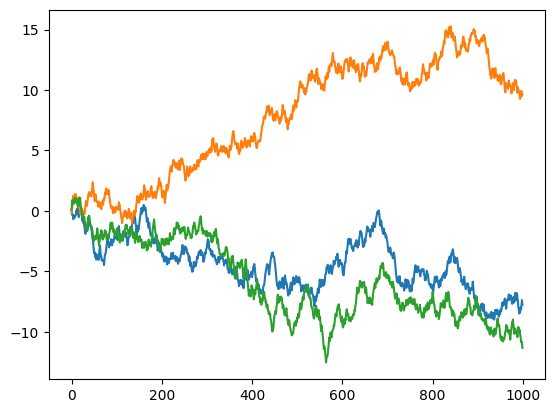

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.319961,-0.264406,0.412477
1,-0.160228,0.162042,0.857017
2,-0.118436,-0.312414,1.039499
3,-0.179157,-0.136080,0.905624
4,0.106275,-0.175827,1.015690
...,...,...,...
95,-5.611640,-1.950910,2.655309
96,-6.093418,-1.678860,2.208047
97,-6.113583,-1.810853,1.837380
98,-6.170969,-1.686025,1.827494


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.054817,-0.468334,-0.358655,0.171084,0.333970
1,-0.431448,-0.033139,-0.235167,-0.240989,0.455410
2,-0.885221,-0.097539,-0.197017,-0.534180,-0.004252
3,-0.433524,0.014149,-0.544321,-0.151831,-0.342732
4,-0.723611,-0.469495,-0.832394,0.059543,0.081241
...,...,...,...,...,...
95,-3.468843,-4.625285,-6.772323,-0.322086,-1.417382
96,-3.135809,-4.982771,-6.309663,-0.363641,-1.552610
97,-3.138786,-4.561381,-6.275718,-0.099932,-1.150103
98,-3.504854,-4.679983,-6.345340,-0.222089,-1.349716


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.264697,0.679114,1.170688,0.796396,0.812828,1.099779,1.439745,1.274866,0.809455,0.897465,...,-3.246523,-3.555149,-3.730575,-3.897302,-3.696672,-3.851080,-3.974567,-4.466595,-4.714917,-4.455080
var_1,-0.349033,-0.762687,-0.459890,-0.941234,-1.033232,-1.010187,-1.087445,-1.497237,-1.574029,-1.414925,...,-3.844993,-3.417937,-3.058122,-3.250879,-3.604480,-3.885500,-3.666333,-3.505226,-3.005507,-2.571968
var_2,-0.056449,0.051937,0.350462,0.820148,0.407851,0.733669,0.656341,0.952692,0.455341,0.931062,...,1.390833,1.556332,2.019461,1.705617,1.494736,1.207888,0.970636,1.351950,1.495699,1.040685
var_3,-0.104266,-0.441506,-0.412073,-0.025724,0.241445,0.708902,0.602297,0.585369,0.352091,0.146364,...,-2.648066,-2.652174,-2.603287,-2.954845,-3.311411,-3.311884,-3.286330,-3.387740,-3.166834,-2.781280
target,0.353224,0.713349,1.205244,1.369705,1.224026,1.462538,1.909034,2.169640,1.835983,2.247840,...,-1.240124,-0.774285,-0.633409,-1.038719,-1.426789,-1.520099,-1.035828,-1.367258,-1.399694,-1.229407


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.431383,-0.500778,-0.804692,-0.916754,-0.478801,-0.143445,0.297113,-0.097000,0.059802,-0.124348,...,0.959766,0.532895,0.288672,0.005849,0.260804,0.278994,0.723576,0.561275,0.615695,0.278314
var_1,-0.275433,-0.099383,0.083307,-0.342529,-0.337763,-0.781313,-0.665347,-1.009603,-1.337883,-1.712804,...,-3.355449,-3.137290,-3.117830,-2.626383,-2.933020,-2.772545,-2.998189,-2.854906,-2.621797,-2.626633
var_2,0.147760,0.499316,0.982527,1.285252,0.931990,0.849599,0.514632,0.743188,0.915480,0.814718,...,1.513217,1.255126,0.780681,0.561323,0.335917,0.018658,0.390820,0.182467,0.409492,0.711409
var_3,0.149110,0.275820,0.695532,0.917512,0.802164,0.764609,1.103311,0.836916,1.058364,1.226116,...,1.561477,1.460009,1.111414,1.365357,1.654572,2.109944,1.915201,1.786268,2.066690,2.557990
target,0.066705,-0.225276,0.165974,0.660072,0.332995,0.325000,0.656403,0.450397,0.370012,0.280894,...,-0.433189,-0.346305,-0.239178,-0.735568,-0.715375,-0.311370,-0.152088,-0.101139,-0.192559,-0.237545


(20, 4, 5) (20,)


In [ ]:
from tsai.data.validation import TrainValidTestSplitter

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.013122,-0.028394,-0.312517,0.110910,-0.314499
1,0.205850,-0.511167,-0.007816,0.072704,-0.369059
2,0.126262,-0.403928,-0.396451,-0.313385,-0.600932
3,0.486570,-0.256807,-0.179497,-0.510231,-0.674591
4,0.184996,-0.706911,-0.523609,-0.147062,-0.410203
...,...,...,...,...,...
95,-0.877013,0.028011,1.322600,2.501647,-3.719120
96,-0.901248,0.236549,1.713976,2.389544,-3.276935
97,-1.115481,-0.256286,2.101846,2.873391,-3.193228
98,-1.478790,-0.438094,1.817453,2.567922,-3.674564


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
data = np.concatenate([np.linspace(0, 1, 11).reshape(-1,1).repeat(2, 1), np.arange(11).reshape(-1,1)], -1)
df_test = pd.DataFrame(data, columns=['col1', 'col2', 'target'])
df_test['target'] = df_test['target'].astype(int)
df_test

,col1,col2,target
0,0.0,0.0,0
1,0.1,0.1,1
2,0.2,0.2,2
3,0.3,0.3,3
4,0.4,0.4,4
5,0.5,0.5,5
6,0.6,0.6,6
7,0.7,0.7,7
8,0.8,0.8,8
9,0.9,0.9,9


In [ ]:
def _y_func(o): return o[:, 0]

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=_y_func)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[2], wl)
    test_close(x[:, 0, 0]*10, y)

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/ wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, len(df_test)+1):
    x, y = SlidingWindow(wl, None, pad_remainder=False, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, 20):
    x, _ = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=[], horizon=0)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(2, len(df_test)):
    x, _ = SlidingWindow(wl, wl, pad_remainder=False, get_x=['col1', 'col2'], get_y=[], horizon=0)(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[2], wl)

In [ ]:
df = pd.DataFrame()
df['sample_id'] = np.concatenate([np.ones(n)*(i + 1) for i,n in enumerate([13])])
df['var1'] = df['sample_id'] + df.index.values - 1
df['var2'] = df['var1'] * 10
df['target'] = (df['var1']).astype(int)
df['sample_id'] = df['sample_id'].astype(int)
df

,sample_id,var1,var2,target
0,1,0.0,0.0,0
1,1,1.0,10.0,1
2,1,2.0,20.0,2
3,1,3.0,30.0,3
4,1,4.0,40.0,4
5,1,5.0,50.0,5
6,1,6.0,60.0,6
7,1,7.0,70.0,7
8,1,8.0,80.0,8
9,1,9.0,90.0,9


In [ ]:
X, y = SlidingWindow(window_len=3, stride=2, start=3, pad_remainder=False, padding="pre", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (2, 2, 3))
test_eq(y.shape, (2, 4))
X, y

(array([[[ 4.,  5.,  6.],
         [40., 50., 60.]],
 
        [[ 6.,  7.,  8.],
         [60., 70., 80.]]]),
 array([[ 7,  8,  9, 10],
        [ 9, 10, 11, 12]]))

In [ ]:
X, y = SlidingWindow(window_len=3, stride=2, start=3, pad_remainder=True, padding="pre", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (3, 2, 3))
test_eq(y.shape, (3, 4))
X, y

(array([[[nan,  3.,  4.],
         [nan, 30., 40.]],
 
        [[ 4.,  5.,  6.],
         [40., 50., 60.]],
 
        [[ 6.,  7.,  8.],
         [60., 70., 80.]]]),
 array([[ 5,  6,  7,  8],
        [ 7,  8,  9, 10],
        [ 9, 10, 11, 12]]))

In [ ]:
X, y = SlidingWindow(window_len=3, stride=2, start=3, pad_remainder=False, padding="post", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (2, 2, 3))
test_eq(y.shape, (2, 4))
X, y

(array([[[ 3.,  4.,  5.],
         [30., 40., 50.]],
 
        [[ 5.,  6.,  7.],
         [50., 60., 70.]]]),
 array([[ 6,  7,  8,  9],
        [ 8,  9, 10, 11]]))

In [ ]:
X, y = SlidingWindow(window_len=3, stride=2, start=3, pad_remainder=True, padding="post", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (3, 2, 3))
test_eq(y.shape, (3, 4))
X, y

(array([[[ 3.,  4.,  5.],
         [30., 40., 50.]],
 
        [[ 5.,  6.,  7.],
         [50., 60., 70.]],
 
        [[ 7.,  8.,  9.],
         [70., 80., 90.]]]),
 array([[ 6.,  7.,  8.,  9.],
        [ 8.,  9., 10., 11.],
        [10., 11., 12., nan]]))

In [ ]:
X, y = SlidingWindow(window_len=10, stride=2, start=3, pad_remainder=True, padding="pre", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (1, 2, 10))
test_eq(y.shape, (1, 4))
X, y

(array([[[nan, nan, nan, nan,  3.,  4.,  5.,  6.,  7.,  8.],
         [nan, nan, nan, nan, 30., 40., 50., 60., 70., 80.]]]),
 array([[ 9, 10, 11, 12]]))

In [ ]:
X, y = SlidingWindow(window_len=10, stride=2, start=3, pad_remainder=True, padding="post", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (1, 2, 10))
test_eq(y.shape, (1, 4))
X, y

(array([[[  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.],
         [ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]]]),
 array([[nan, nan, nan, nan]]))

In [ ]:
#|export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0,
                       pad_remainder:bool=False, padding:str="post", padding_value:float=np.nan, add_padding_feature:bool=True,
                       get_x:Union[None, int, list]=None,  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None,
                       output_processor:Optional[callable]=None, copy:bool=False, horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None,
                       ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.

    Args:
        window_len          = length of lookback window
        unique_id_cols      = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding             = 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence. If pad_remainder == False, it indicates
                              the starting point to create the sequence ('pre' from the end, and 'post' from the beginning)
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict (y). If get_y is [] horizon will be set to 0.
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y.
                              [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        output_processor    = optional function to filter output (X (and y if available)). This is useful when some values need to be removed. The function
                              should take X and y (even if it's None) as arguments.
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
        return_key          = when True, the key corresponsing to unique_id_cols for each sample is returned
        verbose             = controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.


    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    global unique_id_values

    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None:
        if not is_listy(sort_by): sort_by = [sort_by]
        sort_by = [sb for sb in sort_by if sb not in unique_id_cols]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])

    def _SlidingWindowPanel(o):

        if copy:
            o = o.copy()
        o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True, kind="mergesort")
        unique_id_values = o[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        if verbose: print('processing data...')
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, pad_remainder=pad_remainder, padding=padding, padding_value=padding_value,
                                     add_padding_feature=add_padding_feature, get_x=get_x, get_y=get_y, y_func=y_func, output_processor=output_processor,
                                     copy=False, horizon=horizon, seq_first=seq_first,
                                     check_leakage=check_leakage)(o[(o[unique_id_cols].values == v).sum(axis=1) == len(v)])
            if x_v is not None and len(x_v) > 0:
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            elif verbose>=2:
                print(f'cannot use {unique_id_cols} = {v} due to not having enough records')

        if verbose: 
            print('...data processed')
            print('concatenating X...')
        X = np.concatenate(_x)
        print('...X concatenated')
        if _y != []:
            print('concatenating y...')
            y = np.concatenate(_y)
            print('...y concatenated')
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key:
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y

    return _SlidingWindowPanel


SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,86155,861532,8615302,86153000,861530000,8615300000,86153000000,861530000000,8615300000000,86153000000000,86153,2,3,B,186157
1,52009,520072,5200702,52007000,520070000,5200700000,52007000000,520070000000,5200700000000,52007000000000,52007,2,3,B,152011
2,97517,975152,9751502,97515000,975150000,9751500000,97515000000,975150000000,9751500000000,97515000000000,97515,2,3,B,197519
3,97435,974332,9743302,97433000,974330000,9743300000,97433000000,974330000000,9743300000000,97433000000000,97433,2,3,B,197437
4,640,6400,64000,640000,6400000,64000000,640000000,6400000000,64000000000,640000000000,640,0,0,A,640


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((199982, 10, 5), (199982,))

In [ ]:
#|export

def identify_padding(float_mask, value=-1):
    """Identifies padded subsequences in a mask of type float
    
    This function identifies as padded subsequences those where all values == nan 
    from the end of the sequence (last dimension) across all channels, and sets
    those values to the selected value (default = -1)
    
    Args:
        mask: boolean or float mask
        value: scalar that will be used to identify padded subsequences 
    """
    padding = torch.argmax((torch.flip(float_mask.mean((1)) - 1, (-1,)) != 0).float(), -1)
    padded_idxs = torch.arange(len(float_mask))[padding != 0]
    if len(padded_idxs) > 0:
        padding = padding[padding != 0]
        for idx,pad in zip(padded_idxs, padding): float_mask[idx, :, -pad:] = value
    return float_mask

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, _ = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X = tensor(X)
X[0, 1, -2:] = np.nan
X[1,..., :3] = np.nan
print(X)
identify_padding(torch.isnan(X).float())

input shape: (13, 3)
tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  1.,  2., nan, nan],
         [ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  0.,  0.]],

        [[10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [ 0.,  0.,  0.,  1.,  1.]]])


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/011_data.preparation.ipynb saved at 2022-11-09 12:39:40
Correct notebook to script conversion! 😃
Wednesday 09/11/22 12:39:44 CET
